# ARIMA Model

---------

**A**uto **R**egressive **I**ntegrated **M**oving **A**verage



> *The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values. The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past. The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). The purpose of each of these features is to make the model fit the data as well as possible*. -- [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('seaborn-darkgrid')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
shampoo = pd.read_excel('data/ShampooSales.xls')
shampoo.set_index('Month', inplace = True)

In [3]:
shampoo_diff = shampoo.diff().dropna()
train = shampoo_diff[:-5]
test = shampoo_diff[-5:]

### The Autoregressive Model

In [4]:
ar = ARIMA(train, order = (1, 1, 0))

In [5]:
model = ar.fit()

In [6]:
forecast = model.forecast(steps = 5)[0]

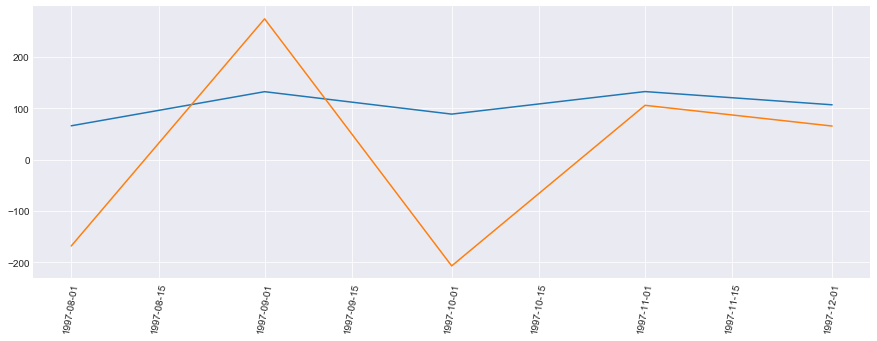

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(test.index, forecast)
plt.plot(test)
plt.xticks(rotation = 80);

### ARIMA Model Parameters

```
order(p, d, q)
```

- d: Augmented Dicky Fuller determines amount of differencing

- p: The lag beyond which the PACF cuts off is the indicated number of AR terms.

- q: The lag beyond which the ACF cuts off is the indicated number of MA terms.

In [8]:
adfuller(shampoo['Shampoo Sales'])[1]

1.0

In [9]:
adfuller(shampoo['Shampoo Sales'].diff().dropna())[1]

1.7998574141686703e-10

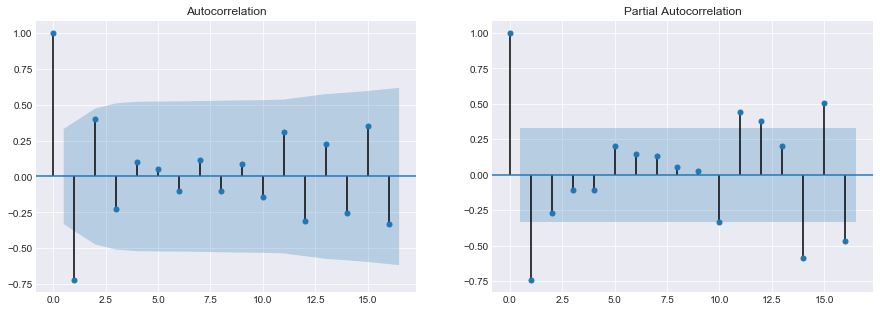

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
plot_acf(shampoo['Shampoo Sales'].diff().dropna(), ax = ax[0])

plot_pacf(shampoo['Shampoo Sales'].diff().dropna(), ax = ax[1]);

In [14]:
arima = ARIMA(train, order=(1, 1, 1))

# instead of q = 0, it is 1 for the moving average

In [15]:
model = arima.fit()

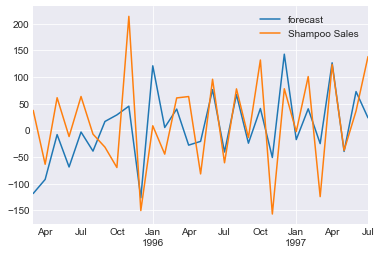

In [16]:
model.plot_predict();

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.Shampoo Sales   No. Observations:                   29
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -165.248
Method:                       css-mle   S.D. of innovations             66.190
Date:                Wed, 28 Apr 2021   AIC                            338.496
Time:                        09:10:01   BIC                            343.966
Sample:                    03-01-1995   HQIC                           340.209
                         - 07-01-1997                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.4517      0.869      1.670      0.095      -0.252       3.155
ar.L1.D.Shampoo Sales    -0.6797      0.138     -4.936      0.000      -0.950      -0.410
ma.L1.D.Shampoo Sales    -1.0000      0.093    -10.802      0.000      -1.181      -0.819
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4713           +0.0000j            1.4713            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [18]:
def arima_summary(order_tup):
    ar = ARIMA(train, order=order_tup)
    model = ar.fit()
    #predict 7 days ahead
    forecast = model.forecast(steps = 5)
    #get predictions
    preds = forecast[0]
    res_df = pd.read_excel('data/ShampooSales.xls', index = 'Month')
    fdf = pd.DataFrame(preds, index = res_df.tail().index)
    res_df['predictions'] = fdf 
    #keep rows with both observations
    
    res_df['predictions'] = res_df['Shampoo Sales'] + res_df['predictions']
    #compute and print errors
    
    
    res_df.set_index('Month', inplace = True)
    res_df.iloc[-5:, 1] = preds
    res_df['predictions'] = res_df['Shampoo Sales'] + res_df['predictions']
    error_df = res_df.tail()
    error_df['squared_error'] = (error_df['Shampoo Sales'] - error_df['predictions'])**2
    res_df.plot(figsize = (15, 5))
    #error_df.set_index('Month', inplace = True)
    mse = np.mean(error_df['squared_error'])
    rmse = np.sqrt(mse)
    print(f'The MSE is {mse}\nThe RMSE is {rmse}')
    return res_df.tail()

The MSE is 2496.1869917339773
The RMSE is 49.961855367209665


,Shampoo Sales,predictions
Month,,
1997-08-01,407.6,364.003136
1997-09-01,682.0,764.335677
1997-10-01,475.3,474.481382
1997-11-01,581.3,639.437380
1997-12-01,646.9,667.405111


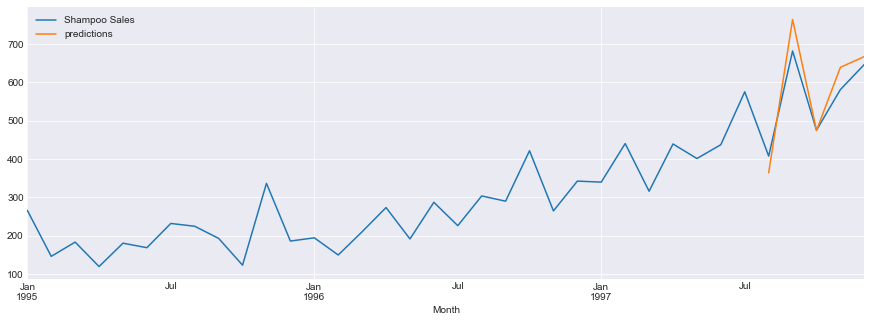

In [19]:
arima_summary((1, 1, 1))

### `pmdarima`

![](pmdarima.png)

In [21]:
!pip install pmdarima
import pmdarima as pm

You should consider upgrading via the 'c:\users\rjsch\anaconda3\python.exe -m pip install --upgrade pip' command.


In [22]:
# fit stepwise auto-ARIMA generates several ARIMA models and compares
# them. The idea is to select the model w/ lowest AIC and plot it for 
# validation
stepwise_fit = pm.auto_arima(shampoo, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=False,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.407, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.873, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.977, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=408.967, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.229, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=404.226, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.463, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 0.865 seconds


In [23]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -195.731
Date:                Wed, 28 Apr 2021   AIC                            401.463
Time:                        09:14:17   BIC                            409.240
Sample:                             0   HQIC                           404.147
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3054      6.175      1.507      0.132      -2.798      21.409
ar.L1          0.0890      0.314      0.284      0.777      -0.526       0.704
ma.L1         -1.3867      0.314     -4.411      0.000      -2.003      -0.771
ma.L2          0.9421      0.448      2.102      0.036       0.064       1.820
sigma2      3697.4321   1455.480      2.540      0.011     844.744    6550.120
===================================================================================
Ljung-Box (Q):                       33.32   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.50   Prob(JB):                         0.67
Heteroskedasticity (H):               0.95   Skew:                             0.30
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

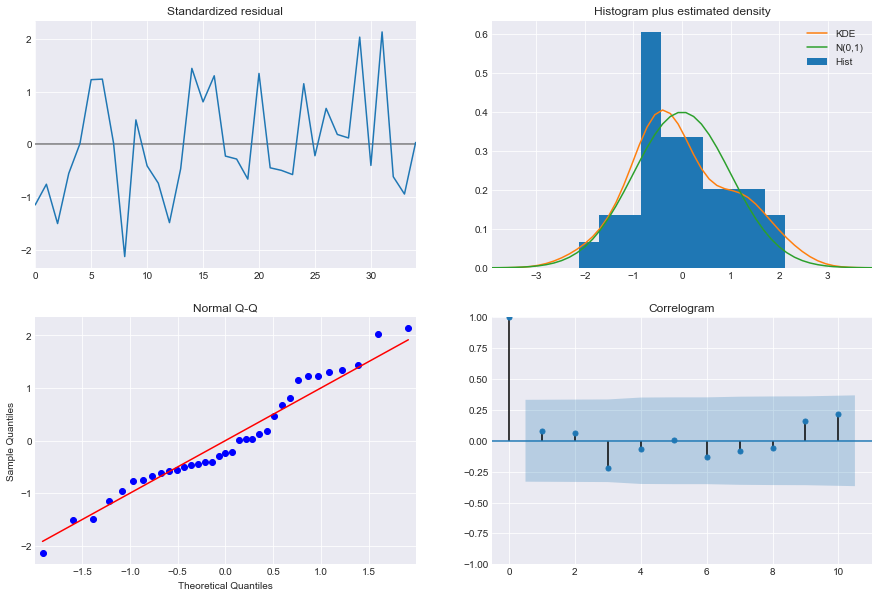

In [24]:
stepwise_fit.plot_diagnostics(figsize = (15, 10));